# Test imports, configs, etc

In [2]:
# custom classes
from SatellitesDataset import get_test_dataset,get_train_dataset,SatellitesDataset
from SatellitesAugs import SatellitesTrainAugmentation,SatellitesTestAugmentation
from Loss import BCEDiceLoss
from LinkNet import LinkNet34
from UNet import UNet11
from presets import preset_dict

preset = 'rgb_ps'
bit8_imgs,bit8_masks,cty_no = get_train_dataset(preset,preset_dict)
or_imgs,cty_no_mask = get_test_dataset(preset,preset_dict)
len(bit8_imgs),len(bit8_masks),len(cty_no),len(or_imgs),len(cty_no_mask)

from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(bit8_imgs,
                                                                bit8_masks,
                                                                test_size=0.2,
                                                                stratify = cty_no,
                                                                random_state=42)

len(train_imgs),len(train_masks)

train_augs = SatellitesTrainAugmentation(shape=1280,
                                         aug_scheme = None
                                        )

val_augs = SatellitesTestAugmentation(shape=1280)

dataset = SatellitesDataset(preset = preset_dict[preset],
            image_paths = train_imgs,
             mask_paths = train_masks,                 
             transforms = train_augs,
            )

Augmentations are NOT enabled for train


In [6]:
import pandas as pd
pd.DataFrame(cty_no)[0].value_counts()

3    1028
0     981
1     283
2     257
Name: 0, dtype: int64

In [4]:
import random

img,mask  = dataset.__getitem__(random.randint(0,100))

In [7]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.85227275, 0.85227275,
        0.85227275],
       [0.        , 0.        , 0.        , ..., 0.85227275, 0.85227275,
        0.85227275],
       [0.        , 0.        , 0.        , ..., 0.01704546, 0.01704546,
        0.01704546]], dtype=float32)

start
image processing complete 0.12017488479614258


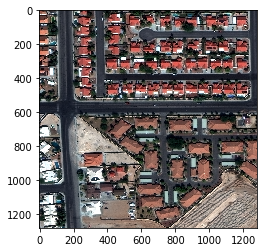

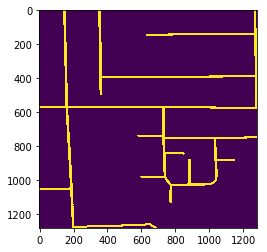

plotting complete 0.42572522163391113


In [25]:
import matplotlib.pyplot as plt
import time
import random
import numpy as np

start = time.time()
print("start")

img,mask  = dataset.__getitem__(random.randint(0,100))

end = time.time()
print('image processing complete', end - start)

img = img.cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

mask = mask.cpu().numpy().astype(np.float32).transpose((1, 2, 0))[:,:,0]
mask += -mask.min()
mask *= (1/mask.max())

plt.imshow(mask)
plt.show()

end = time.time()
print('plotting complete', end - start)

In [4]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

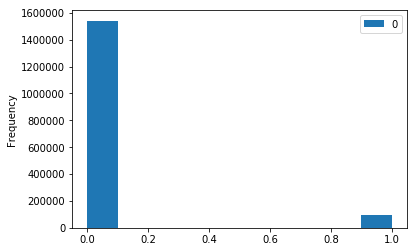

In [5]:
import pandas as pd

df = pd.DataFrame(mask.reshape(-1,1))
df.plot(kind='hist')
plt.show()

In [6]:
img,mask  = dataset.__getitem__(random.randint(0,100))

In [11]:
mask.min()

0.0

In [26]:
1280*1280

1638400

In [23]:
(np.asarray(mask) > 0.5).astype(np.uint8).sum()

122794

In [12]:
test.astype(np.uint8)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
    print('Train images: {}\t'
          'Train  masks: {}\t'
          'Val   images: {}\t'
          'Val    masks: {}\t'.format(len([1]),len([1]),
                                      len([1]),len([1])))

Train images: 1	Train  masks: 1	Val   images: 1	Val    masks: 1	


In [27]:
import shutil

shutil.rmtree('tb_logs/test/')

PermissionError: [Errno 13] Permission denied: 'events.out.tfevents.1515653499.4c3715934f1a'

# Try the 8-channel model

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import torch.nn.functional as F

nonlinearity = nn.ReLU

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity(inplace=True)

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3,
                                          stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity(inplace=True)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class LinkNet34(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super().__init__()
        
        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)

        # self.firstconv = resnet.conv1
        # assert num_channels == 3, "num channels not used now. to use changle first conv layer to support num channels other then 3"
        # try to use 8-channels as first input
        if num_channels==3:
            self.firstconv = resnet.conv1
        else:
            self.firstconv = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nonlinearity(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nonlinearity(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        # d4 = e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        # return f5 
        return F.sigmoid(f5)

In [14]:
model = LinkNet34(num_classes=1,
                 num_channels=8)

In [15]:
model

LinkNet34 (
  (firstconv): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (firstrelu): ReLU (inplace)
  (firstmaxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (encoder1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): 

In [16]:
inputs = torch.autograd.Variable(torch.randn(1,8,320,320))
out = model(inputs)
print (out.size())

torch.Size([1, 1, 320, 320])


In [29]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

def concat(xs):
    return torch.cat(xs, 1)

class Conv3BN(nn.Module):
    def __init__(self, in_: int, out: int, bn=False):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.bn = nn.BatchNorm2d(out) if bn else None
        self.activation = nn.SELU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        x = self.activation(x)
        return x

class UNetModule(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.l1 = Conv3BN(in_, out)
        self.l2 = Conv3BN(out, out)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)      
    
class UNet11(nn.Module):
    def __init__(self,
                 
                 num_classes=1,
                 num_filters=32,
                 num_channels=3):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        encoder = models.vgg11(pretrained=True).features
        self.relu = encoder[1]
        
        # try to use 8-channels as first input
        if num_channels==3:
            self.conv1 = self.encoder[0]
        else:
            self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))    
        
        self.conv2 = encoder[3]
        self.conv3s = encoder[6]
        self.conv3 = encoder[8]
        self.conv4s = encoder[11]
        self.conv4 = encoder[13]
        self.conv5s = encoder[16]
        self.conv5 = encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return F.sigmoid(self.final(dec1))


In [31]:
model = UNet11(num_classes=1,
               num_filters=32,
               num_channels=8)

model

UNet11 (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (relu): ReLU (inplace)
  (conv1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): DecoderBlock (
    (block): Sequential (
      (0): ConvRelu (
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU (inplace)
      )
      (1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(

In [32]:
inputs = torch.autograd.Variable(torch.randn(1,8,320,320))
out = model(inputs)
print (out.size())

torch.Size([1, 1, 320, 320])


# Generate masks by myself 

In [6]:
!ls ../data/AOI_2_Vegas_Roads_Train/summaryData

AOI_2_Vegas_Roads_Train.csv


In [3]:
from presets import preset_dict

data_prefix = '../data'

folders = ['AOI_2_Vegas_Roads_Train',
           'AOI_5_Khartoum_Roads_Train',
           'AOI_3_Paris_Roads_Train',
           'AOI_4_Shanghai_Roads_Train']



In [4]:
import os

path = os.path.join(data_prefix,folders[0],'summaryData',folders[0]+'.csv')

In [98]:
import pandas as pd

ls_df = pd.read_csv(path)
ls_df.tail()

,ImageId,WKT_Pix
17930,AOI_2_Vegas_img592,"LINESTRING (750.37 1300.00, 750.77 1122.87, 75..."
17931,AOI_2_Vegas_img592,"LINESTRING (769.91 0.00, 770.80 123.01, 749.51..."
17932,AOI_2_Vegas_img592,"LINESTRING (750.77 1122.87, 1012.74 1114.56, 1..."
17933,AOI_2_Vegas_img592,"LINESTRING (751.70 720.78, 1005.50 715.97)"
17934,AOI_2_Vegas_img592,"LINESTRING (1300.00 576.57, 1002.96 576.00, 10..."


In [137]:
ls_df.iloc[34]

ImageId                            AOI_2_Vegas_img1116
WKT_Pix    LINESTRING (678.34 1263.84, 624.61 1300.00)
Name: 34, dtype: object

In [99]:
ls_df[ls_df.ImageId=='AOI_2_Vegas_img592']

,ImageId,WKT_Pix
17918,AOI_2_Vegas_img592,"LINESTRING (19.78 1300.00, 11.02 0.00)"
17919,AOI_2_Vegas_img592,"LINESTRING (108.28 347.02, 324.93 347.03, 652...."
17920,AOI_2_Vegas_img592,"LINESTRING (325.77 405.27, 109.39 409.71)"
17921,AOI_2_Vegas_img592,"LINESTRING (122.81 873.09, 125.18 1035.66, 538..."
17922,AOI_2_Vegas_img592,"LINESTRING (603.77 1193.42, 122.81 1201.78, 12..."
17923,AOI_2_Vegas_img592,"LINESTRING (324.11 290.42, 324.93 347.03, 325...."
17924,AOI_2_Vegas_img592,"LINESTRING (752.69 286.54, 653.11 287.45, 324...."
17925,AOI_2_Vegas_img592,"LINESTRING (751.38 857.67, 606.93 854.70, 601...."
17926,AOI_2_Vegas_img592,"LINESTRING (601.88 1300.00, 603.77 1193.42, 60..."
17927,AOI_2_Vegas_img592,"LINESTRING (752.13 533.44, 611.51 532.33, 610...."


In [9]:
sample

,Unnamed: 0,width,height,channels,im_size,ctime,mtime,img_files,img_folders,img_subfolders
1428,1428,1300,1300,1,3383838,1.515131e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,PAN,PAN_AOI_2_Vegas_img885.tif
2414,2414,1300,1300,3,10150778,1.515131e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,RGB-PanSharpen,RGB-PanSharpen_AOI_2_Vegas_img885.tif
3645,3645,1300,1300,8,27050820,1.515132e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,MUL-PanSharpen,MUL-PanSharpen_AOI_2_Vegas_img885.tif
5246,5246,325,325,8,1693020,1.515131e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,MUL,MUL_AOI_2_Vegas_img885.tif


In [200]:
import numpy as np
from skimage.io import imread
from skimage import img_as_ubyte,img_as_float
from skimage import exposure
from skimage.draw import circle
import cv2
from collections import Counter
        
def read_image(preset,path):
    img = imread(path)
    target_channels = np.zeros(shape=(preset['width'],preset['width'],len(preset['channels'])))

    # expand grayscale images to 3 dimensions
    if len(img.shape)<3:
        img = np.expand_dims(img, 2)                

    for i,channel in enumerate(preset['channels']):
        target_channels[:,:,i] = img[:,:,channel-1]

    # target_channels = img_as_ubyte(target_channels)
    # target_channels = exposure.rescale_intensity(target_channels, in_range='uint8')           

    return target_channels
    
def draw_mask(circle_size,
              line_width,
              ls_list,
              mask_size
             ):

    ls_lines = [(line[len('LINESTRING ('):-1]) for line in ls_list]

    mask = np.zeros((mask_size, mask_size), dtype=np.uint8)
    all_points = []
    
    for line in ls_lines:
        points = line.split(', ')
        points_xy = []
        for point in points:
            x,y = point.split()
            points_xy.append([x,y])
        
        all_points.extend(points_xy)
        
        for i,[x,y] in enumerate(points_xy):
            if i-1>-1:
                prev_x = int(float(points_xy[i-1][0]))
                prev_y = int(float(points_xy[i-1][1]))
                mask = cv2.line(mask,(prev_x,prev_y),(int(float(x)),int(float(y))),(150),line_width)
                
        all_points_text = [(point[0]+' '+point[1]) for point in all_points]
        count_dict =  Counter(all_points_text)
        for key, value in count_dict.items():
            if(value>1):
                x,y = key.split()
                rr, cc = circle(int(float(y)), int(float(x)), circle_size)
                mask[rr.clip(min=0,max=mask_size-1), cc.clip(min=0,max=mask_size-1)] = 255
    return mask

meta_df = pd.read_csv('../metadata.csv')
meta_df.head()
sample = meta_df[meta_df.img_subfolders.str.contains("AOI_2_Vegas_img1116") ]
ls_list = list(ls_df[ls_df.ImageId=='AOI_2_Vegas_img1116'].WKT_Pix.values)

img_path1 = os.path.join(data_prefix,sample[sample.img_folders=='PAN'].img_files.values[0],sample[sample.img_folders=='PAN'].img_folders.values[0],sample[sample.img_folders=='PAN'].img_subfolders.values[0])
img_path2 = os.path.join(data_prefix,sample[sample.img_folders=='RGB-PanSharpen'].img_files.values[0],sample[sample.img_folders=='RGB-PanSharpen'].img_folders.values[0],sample[sample.img_folders=='RGB-PanSharpen'].img_subfolders.values[0])
img_path3 = os.path.join(data_prefix,sample[sample.img_folders=='MUL-PanSharpen'].img_files.values[0],sample[sample.img_folders=='MUL-PanSharpen'].img_folders.values[0],sample[sample.img_folders=='MUL-PanSharpen'].img_subfolders.values[0])
img_path4 = os.path.join(data_prefix,sample[sample.img_folders=='MUL'].img_files.values[0],sample[sample.img_folders=='MUL'].img_folders.values[0],sample[sample.img_folders=='MUL'].img_subfolders.values[0])

img1 = read_image(preset_dict['pan'],img_path1)
img2 = read_image(preset_dict['rgb_ps'],img_path2)
img3 = read_image(preset_dict['mul_ps_vegetation'],img_path3)
img4 = read_image(preset_dict['mul_vegetation'],img_path4)

mask = draw_mask(circle_size=15,
              line_width=15,
              ls_list=ls_list,
              mask_size=1300
             )

mask2 = imread('../data/AOI_2_Vegas_Roads_Train/PAN_mask/PAN_AOI_2_Vegas_img1116.jpg')

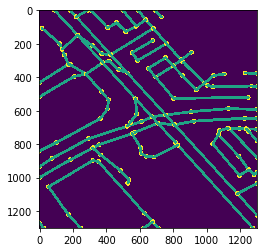

In [174]:
def draw_mask(circle_size,
              line_width,
              ls_list,
              mask_size
             ):

    ls_lines = [(line[len('LINESTRING ('):-1]) for line in ls_list]

    mask = np.zeros((mask_size, mask_size), dtype=np.uint8)
    all_points = []
           
    for line in ls_lines:
        points = line.split(', ')
        points_xy = []
        for point in points:
            x,y = point.split()
            points_xy.append([x,y])
            rr, cc = circle(int(float(y)), int(float(x)), circle_size)
            mask[rr.clip(min=0,max=mask_size-1), cc.clip(min=0,max=mask_size-1)] = 255
        
        all_points.extend(points_xy)
        
        for i,[x,y] in enumerate(points_xy):
            if i-1>-1:
                prev_x = int(float(points_xy[i-1][0]))
                prev_y = int(float(points_xy[i-1][1]))
                mask = cv2.line(mask,(prev_x,prev_y),(int(float(x)),int(float(y))),(150),line_width)
    return mask,all_points

mask,all_points = draw_mask(circle_size=15,
              line_width=15,
              ls_list=ls_list,
              mask_size=1300
             )

plt.imshow(mask)
plt.show()   

In [176]:
set(all_points)

TypeError: unhashable type: 'list'

In [153]:
!ls ../data/AOI_2_Vegas_Roads_Train/PAN_mask/*img1116*

../data/AOI_2_Vegas_Roads_Train/PAN_mask/PAN_AOI_2_Vegas_img1116.jpg


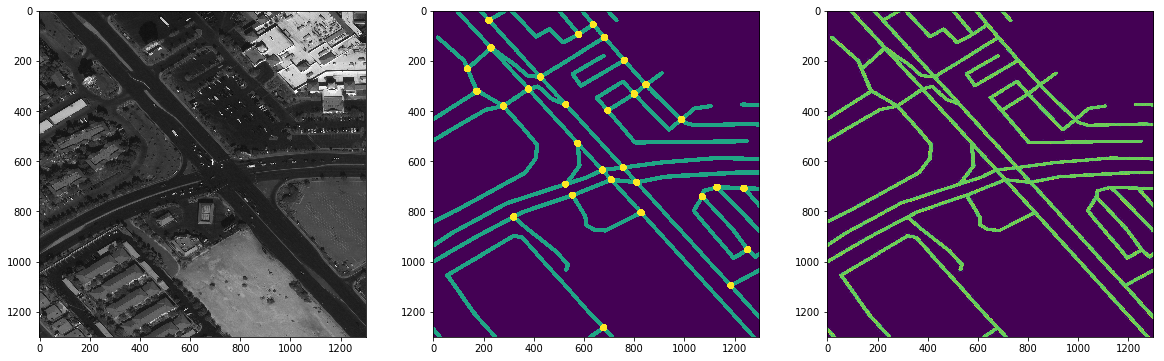

In [201]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 6))

fig.add_subplot(1, 3, 1)
img1 += -img1.min()
img1 *= (1/img1.max())
plt.imshow(img1)

fig.add_subplot(1, 3, 2)
plt.imshow(mask)

fig.add_subplot(1, 3, 3)
plt.imshow(mask2)


plt.show()     

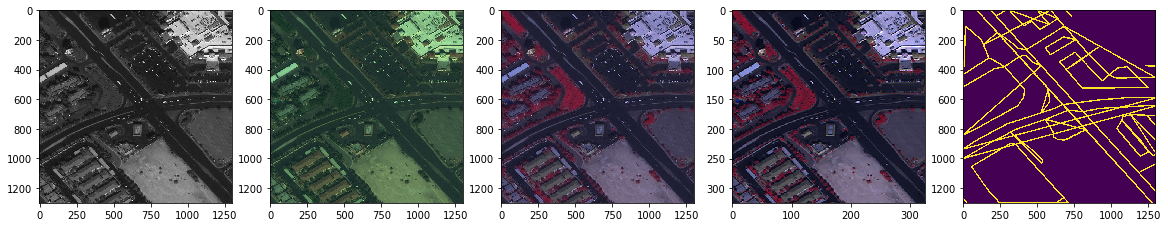

In [143]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20, 5))

fig.add_subplot(1, 5, 1)
img1 += -img1.min()
img1 *= (1/img1.max())
plt.imshow(img1)

fig.add_subplot(1, 5, 2)
img2 += -img2.min()
img2 *= (1/img2.max())
plt.imshow(img2)

fig.add_subplot(1, 5, 3)
img3 += -img3.min()
img3 *= (1/img3.max())
plt.imshow(img3)

fig.add_subplot(1, 5, 4)
img4 += -img4.min()
img4 *= (1/img4.max())
plt.imshow(img4)

fig.add_subplot(1, 5, 5)
plt.imshow(mask)

plt.show()     

In [69]:
for i,[x,y] in enumerate(points_xy):
    print(i,x,y)

0 1145.53 319.63
1 1142.97 0.00


In [81]:
(int(float(x)),int(float(y)))

(1300, 662)

In [63]:
cc.clip(min=0,max=1300)

array([660, 661, 662, 663, 664, 659, 660, 661, 662, 663, 664, 665, 658,
       659, 660, 661, 662, 663, 664, 665, 666, 658, 659, 660, 661, 662,
       663, 664, 665, 666, 658, 659, 660, 661, 662, 663, 664, 665, 666,
       658, 659, 660, 661, 662, 663, 664, 665, 666, 658, 659, 660, 661,
       662, 663, 664, 665, 666, 659, 660, 661, 662, 663, 664, 665, 660,
       661, 662, 663, 664])

In [60]:
rr, cc

(array([1296, 1296, 1296, 1296, 1296, 1297, 1297, 1297, 1297, 1297, 1297,
        1297, 1298, 1298, 1298, 1298, 1298, 1298, 1298, 1298, 1298, 1299,
        1299, 1299, 1299, 1299, 1299, 1299, 1299, 1299, 1300, 1300, 1300,
        1300, 1300, 1300, 1300, 1300, 1300, 1301, 1301, 1301, 1301, 1301,
        1301, 1301, 1301, 1301, 1302, 1302, 1302, 1302, 1302, 1302, 1302,
        1302, 1302, 1303, 1303, 1303, 1303, 1303, 1303, 1303, 1304, 1304,
        1304, 1304, 1304]),
 array([660, 661, 662, 663, 664, 659, 660, 661, 662, 663, 664, 665, 658,
        659, 660, 661, 662, 663, 664, 665, 666, 658, 659, 660, 661, 662,
        663, 664, 665, 666, 658, 659, 660, 661, 662, 663, 664, 665, 666,
        658, 659, 660, 661, 662, 663, 664, 665, 666, 658, 659, 660, 661,
        662, 663, 664, 665, 666, 659, 660, 661, 662, 663, 664, 665, 660,
        661, 662, 663, 664]))

In [57]:
float('1300.00')

1300.0

In [49]:
points[0].split()

['1145.53', '319.63']

In [38]:
ls_list

['LINESTRING (1300.00 662.42, 1231.00 657.56, 1145.83 659.57, 614.48 673.81, 324.44 677.31, 0.00 691.09)',
 'LINESTRING (314.59 1300.00, 315.13 1229.58, 324.44 677.31, 327.09 327.01, 585.36 325.30, 1145.53 319.63)',
 'LINESTRING (327.09 327.01, 323.18 0.00)',
 'LINESTRING (911.19 1138.18, 611.40 1139.32, 586.99 1116.60, 407.11 1124.05, 380.50 1154.92, 380.50 1221.98, 383.69 1293.29, 387.33 1300.00)',
 'LINESTRING (437.92 1300.00, 474.45 1282.97)',
 'LINESTRING (1145.53 319.63, 1145.83 659.57, 1141.16 1300.00)',
 'LINESTRING (1145.53 319.63, 1142.97 0.00)']

In [31]:
!ls $img1

../data/AOI_2_Vegas_Roads_Train/PAN/PAN_AOI_2_Vegas_img885.tif


In [ ]:
img = read_image(preset,path)

In [ ]:
def 

In [ ]:
import numpy as np
import pandas as pd
import re
import rasterio
from PyQt5.QtGui import QPainter, QColor, QImage, QPolygonF
from PyQt5 import QtCore, QtGui
from PyQt5.QtCore import Qt


data_dir = '../input/SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/'
roads_data = pd.read_csv(data_dir+'summaryData/AOI_2_Vegas_Roads_Sample.csv')
roads_data.head()

img_id = 'AOI_2_Vegas_img1454'
lines = list(roads_data[roads_data.ImageId == img_id].WKT_Pix)

mask = QImage(1300, 1300, QImage.Format_RGB32)
mask.fill(Qt.black)

painter = QPainter(mask)
pen = QtGui.QPen(Qt.white)
pen.setWidth(16)
pen.setCapStyle(Qt.RoundCap)
painter.setPen(pen)

for i, line in enumerate(lines):
    items = line[len('LINESTRING ('):-1].split(',')
    points = []

    polygon = QPolygonF()
    for item in items:
        x, y = item.split()
        point = [float(x), float(y)]
        points.append(point)
        polygon.append(QtCore.QPointF(point[0], point[1]))
    print(points)
    painter.drawPolyline(polygon)


painter.end()
mask.save(f'mask.png')

# Extend generator so that it works with 8-channel images

In [226]:
torch.randn(1,8,320,320)

4.821369647979736

In [285]:
'mul_ps_8channel' in ['mul_ps_8channel','mul_8channel']

True

In [267]:
import cv2
import time 
import types
import numpy as np
from numpy import random
import random
import imgaug as ia
from imgaug import augmenters as iaa
from torchvision import transforms
from PIL import Image
import torch

seed = 43

class SatellitesTrainAugmentation(object):
    def __init__(self,
                 shape=1280,
                 aug_scheme=None):
        
        if aug_scheme == True:
            print('Augmentations are enabled for train')
            self.augment = Compose([
                    NpyToPil(),
                    transforms.Scale(shape),
                    PilToNpy(),
                    ImgAugAugs(),            
                    ToTensor(),
                ])
        else:
            print('Augmentations are NOT enabled for train')
            self.augment = Compose([
                    NpyToPil(),
                    transforms.Scale(shape),
                    PilToNpy(),
                    ToTensor(),
                ])            
        
    def __call__(self, img, mask):
        global seed        
        seed = random.randint(0,10000)
        
        # naive solution to working with 8-channel images 
        if img.shape[2]>3:
            img1 = self.augment(img[:,:,0:3]) 
            img2 = self.augment(img[:,:,3:6])
            img2 = self.augment(img[:,:,5:8])
            img = torch.cat((img1[0:3,:,:],img1[0:3,:,:],img1[1:3,:,:]))
        else:
            img = self.augment(img)
        mask = self.augment(mask)        
        return img,mask
class SatellitesTestAugmentation(object):
    def __init__(self,shape=1280):
        self.augment = Compose([
                NpyToPil(),
                transforms.Scale(shape),
                PilToNpy(),            
                ToTensor(),
            ])
    def __call__(self, img, mask):
        return self.augment(img),self.augment(mask)
class ImgAugAugs(object):
    def __call__(self,
                 image):
        global seed        
        ia.seed(seed)
        seq = iaa.Sequential([
            # execute 0 to 1 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong            
            iaa.Fliplr(0.25), # horizontally flip 25% of all images
            iaa.Flipud(0.25), # vertically flip 25% of all images         
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            iaa.Sometimes(0.25,            
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    shear=(-5, 5)
                ),   
            ),
        ], random_order=True) # apply augmenters in random order        

        return seq.augment_image(image)    
class Normalize(object):
    def __init__(self,mean,std):
        self.mean = np.array(mean, dtype=np.float32)
        self.std = np.array(std, dtype=np.float32)
    def __call__(self, image):
        image = image.astype(np.float32)
        image[:,:,0:3] -= self.mean
        image[:,:,0:3] *= (1/self.std)
        return image.astype(np.float32)
class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img    
class ToCV2Image(object):
    def __call__(self, tensor):
        return tensor.cpu().numpy().astype(np.float32).transpose((1, 2, 0))
class PilToNpy(object):
    def __call__(self, pil_image):
        return np.array(pil_image)    
class NpyToPil(object):
    def __call__(self, cv2_image):
        return Image.fromarray(cv2_image)  
class ToTensor(object):
    def __call__(self, cvimage):
        # process masks
        if len(cvimage.shape)<3:
            cvimage = np.expand_dims(cvimage, 2)
            cvimage = (cvimage > 255 * 0.5).astype(np.uint8)
            return torch.from_numpy(cvimage).permute(2, 0, 1).float()       
        else:
            # process images
            try:
                return torch.from_numpy(cvimage).permute(2, 0, 1).float().div(float(cvimage.max()))
            except:
                return torch.from_numpy(np.flip(cvimage.transpose((2, 0, 1)),axis=0).copy()).float().div(float(cvimage.max()))
class CannyEdges(object):
    def __init__(self,threshold1=100,threshold2=200):
        self.threshold1 = threshold1
        self.threshold2 = threshold2
    def __call__(self, image):
        canny_region = np.uint8(image[:,:,0:3])
        edges = cv2.Canny(canny_region,self.threshold1,self.threshold2)
        return np.dstack( ( image,edges) ) 
class SaliencyMap(object):
    def __call__(self, image):
        sm = pySaliencyMap(image.shape[0], image.shape[1])
        return np.dstack( ( image,sm.SMGetSM(image)) ) 
class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),
            ConvertColor(transform='HSV'),
            RandomSaturation(),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast()
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image):
        im = image.copy()
        im = self.rand_brightness(im)
        if random.randint(1,2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im = distort(im)
        return self.rand_light_noise(im)
class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image):
        if random.randint(1,2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image
class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image):
        if random.randint(1,2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image
class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image):
        if random.randint(1,2):
            swap = self.perms[random.randint(0,len(self.perms)-1)]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image
class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image
class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image):
        if random.randint(1,2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image
class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image):
        if random.randint(1,2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image    
class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32)
class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image

In [268]:
# custom classes
from SatellitesDataset import get_test_dataset,get_train_dataset,SatellitesDataset
from Loss import BCEDiceLoss
from LinkNet import LinkNet34
from UNet import UNet11
from presets import preset_dict

preset = 'mul_ps_8channel'
bit8_imgs,bit8_masks,cty_no = get_train_dataset(preset,preset_dict)
or_imgs,cty_no_mask = get_test_dataset(preset,preset_dict)
len(bit8_imgs),len(bit8_masks),len(cty_no),len(or_imgs),len(cty_no_mask)

from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(bit8_imgs,
                                                                bit8_masks,
                                                                test_size=0.2,
                                                                stratify = cty_no,
                                                                random_state=42)

len(train_imgs),len(train_masks)

train_augs = SatellitesTrainAugmentation(shape=1280,
                                         aug_scheme = True
                                        )

val_augs = SatellitesTestAugmentation(shape=1280)

dataset = SatellitesDataset(preset = preset_dict[preset],
            image_paths = train_imgs,
             mask_paths = train_masks,                 
             transforms = train_augs,
            )

img,mask  = dataset.__getitem__(random.randint(0,100))


Augmentations are enabled for train


In [269]:
img.shape

torch.Size([8, 1280, 1280])

In [237]:
img.max()

1.0

start
image processing complete 0.5210919380187988


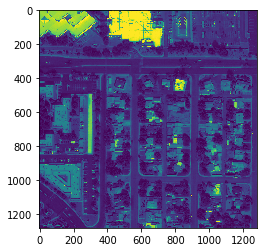

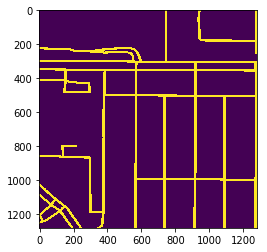

plotting complete 0.8657972812652588


In [284]:
import matplotlib.pyplot as plt
import time
import random
import numpy as np

start = time.time()
print("start")

img,mask  = dataset.__getitem__(random.randint(0,100))

end = time.time()
print('image processing complete', end - start)

img = img.cpu().numpy().astype(np.float32).transpose((1, 2, 0))[:,:,6]
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

mask = mask.cpu().numpy().astype(np.float32).transpose((1, 2, 0))[:,:,0]
mask += -mask.min()
mask *= (1/mask.max())

plt.imshow(mask)
plt.show()

end = time.time()
print('plotting complete', end - start)